<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/split_lucid_notebooks/render_lucid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and imports

In [1]:
%tensorflow_version 1.x

!pip uninstall lucid -y
!pip install git+https://github.com/tensorflow/lucid.git#egg=lucid

!git clone https://github.com/arunraja-hub/Preference_Extraction.git

!pip install tf-agents==0.3.0

!pip uninstall tensorflow-probability -y
!pip install tensorflow-probability==0.7.0

!npm install -g svelte-cli@2.2.0

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

TensorFlow 1.x selected.
Uninstalling lucid-0.3.8:
  Successfully uninstalled lucid-0.3.8
  Cloning https://github.com/tensorflow/lucid.git to /tmp/pip-install-8ufuy0yk/lucid
  Running command git clone -q https://github.com/tensorflow/lucid.git /tmp/pip-install-8ufuy0yk/lucid
  Created wheel for lucid: filename=lucid-0.3.9-cp36-none-any.whl size=155742 sha256=420d100f6e4a34e27e5e67363e19f1e404651d00327a8353df7c58b81c5d099e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1s8a0jq9/wheels/64/c2/51/7238e75f457453774587708b21cd3cf32f9a86456648688634
Successfully built lucid
Cloning into 'Preference_Extraction'...
remote: Enumerating objects: 560, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (547/547), done.
remote: Total 560 (delta 32), reused 519 (delta 12), pack-reused 0
Receiving objects: 100% (560/560), 20.84 MiB | 1.90 MiB/s, done.
Resolving deltas: 100% (32/32), done.
     |████████████████████████████████| 839kB 26.5MB/s 
     |██████████

In [2]:
import numpy as np

from tf_agents.trajectories.time_step import TimeStep
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import TensorSpec
from tf_agents.specs.tensor_spec import BoundedTensorSpec
from tf_agents.networks import q_network

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map


import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import numpy as np
import io
import collections

import urllib.request
from urllib.error import HTTPError

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


# Lucid HTML stuff.
Copied from https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/building-blocks/NeuronGroups.ipynb

In [5]:
%%html_define_svelte GroupWidget

<div class="figure" style="width: 600px;">
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <img src="{{img}}">
    {{#if pres_n != undefined}}
    <img src="{{spatial_factors[pres_n]}}" class="overlay"  >
    {{/if}}
  </div>
   
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <div style="width:100%; height: 100%; background-color: #000;"></div>
    {{#each range(n_groups) as n}}
    {{#if pres_n == undefined || pres_n == n}}
    <img src="{{spatial_factors[n]}}" class="factor" 
         style="filter: hue-rotate({{n*360/n_groups}}deg);">
    {{/if}}
    {{/each}}
  </div>
  
  <br>
  <br>
  
  <div on:mouseleave="set({pres_n: undefined})">
    {{#each range(n_groups) as n}}
    <div class="group" style="background-color: hsl({{n*360/n_groups}}, 80%, 50%); "
         on:mouseover="set({pres_n: n})">
      <img src="{{group_icons[n]}}">
    </div>
    {{/each}}
  </div>
  
</div>


<style>
  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .factor {
    mix-blend-mode: lighten;
  }
  .overlay {
    filter: grayscale(100%) brightness(3);
    mix-blend-mode: multiply;
  }
  .group {
    width: 80px;
    height: 80px;
    margin-right: 4px;
    display: inline-block;
    padding-top: 10px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        n_groups: 1,
        spatial_factors: [""],
        group_icons: [""],
        pres_n: undefined,
        
      };
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_4idl4yiu/GroupWidget_fa0890c2_4453_432a_8154_56841a98200c.html > /tmp/svelte_4idl4yiu/GroupWidget_fa0890c2_4453_432a_8154_56841a98200c.js
b'svelte version 1.64.1\ncompiling ../tmp/svelte_4idl4yiu/GroupWidget_fa0890c2_4453_432a_8154_56841a98200c.html...\n(4:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(6:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(14:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(27:6) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n'


# Read data

In [0]:
class Trajectory(
    collections.namedtuple('Trajectory', [
        'step_type',
        'observation',
        'action',
        'policy_info',
        'next_step_type',
        'reward',
        'discount',
    ])):
  """Stores the observation the agent saw and the action it took.
      The rest of the attributes aren't used in this code."""
  __slots__ = ()

class ListWrapper(object):
  def __init__(self, list_to_wrap):
    self._list = list_to_wrap

  def as_list(self):
    return self._list

class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
      if name == "Trajectory":
        return Trajectory
      if name == "ListWrapper":
        return ListWrapper

      return super(RenameUnpickler, self).find_class(module, name)

def rename_load(s):
    """Helper function analogous to pickle.loads()."""
    return RenameUnpickler(s, encoding='latin1').load()

In [0]:
# Modified read trajectories functions to read files from local storage

def load_file(full_path):
    try:
        with open(full_path, 'rb') as f:
            data = rename_load(f)
            return data
    except:
        return None
    
def all_load_data(base_path):
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    
    futures = []
    for i in range(5000):
        full_path = os.path.join(base_path, "ts"+str(i)+".pickle")
        future = executor.submit(load_file, full_path)
        futures.append(future)
    
    raw_data = []
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            raw_data.append(result)
    
    return raw_data


all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")

In [0]:
single_observation = np.array([all_raw_data[0].observation[0]])

# Load model and run lucid grouping code

In [4]:
model = models.Model.load("Preference_Extraction/lucid_save_model.pb")
model.load_graphdef()

In [14]:
# This is modified from the neuron_groups funciton in https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/building-blocks/NeuronGroups.ipynb to handle 5 channels instead of 3.
input_shape = [14, 16, 5]

img = single_observation[0]
layer = "QNetwork/EncodingNetwork/EncodingNetwork/conv2d/Relu"
n_groups=6

# Compute activations

with tf.Graph().as_default(), tf.Session():
  t_input = tf.placeholder_with_default(img, input_shape, name="lucid_placeholder")
  T = render.import_model(model, t_input, t_input)
  acts = T(layer).eval()

# We'll use ChannelReducer (a wrapper around scikit learn's factorization tools)
# to apply Non-Negative Matrix factorization (NMF).

nmf = ChannelReducer(n_groups, "NMF")
spatial_factors = nmf.fit_transform(acts)[0]
spatial_factors = spatial_factors.transpose(2, 0, 1).astype("float32")
channel_factors = nmf._reducer.components_.astype("float32")

# Let's organize the channels based on their horizontal position in the image

x_peak = np.argmax(spatial_factors.max(1), 1)
ns_sorted = np.argsort(x_peak)
spatial_factors = spatial_factors[ns_sorted]
channel_factors = channel_factors[ns_sorted]

# And create a feature visualziation of each group

param_f = lambda: param.image(80, batch=n_groups, channels=input_shape[-1])
obj = sum(objectives.direction(layer, channel_factors[i], batch=i)
          for i in range(n_groups))
group_icons = render.render_vis(model, obj, param_f, verbose=False)[-1]

# We'd also like to know about attribution

# First, let's turn each group into a vector over activations
group_vecs = [spatial_factors[i, ..., None]*channel_factors[i]
              for i in range(n_groups)]

# attrs = np.asarray([raw_class_group_attr(img, layer, attr_class, group_vecs)
#                    for attr_class in attr_classes])

# print(attrs)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



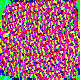
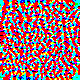
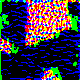
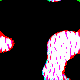
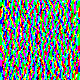
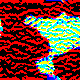

In [15]:
# Let's render the visualization!

lucid_svelte.GroupWidget({
  "img" : _image_url(img[:, :, :3]),
  "n_groups": n_groups,
  "spatial_factors": [_image_url(factor[..., None]/np.percentile(spatial_factors,99)*[1,0,0]) for factor in spatial_factors], 
  "group_icons": [_image_url(icon) for icon in group_icons[:, :, :, :3]] 
})
